# Environment

## Libraries

In [1]:
import os, subprocess, requests, getpass, urllib.parse, sys, pathlib, string, spacy, bs4, \
numpy as np, seaborn as sns, pandas as pd, matplotlib.pyplot as plt, google.cloud.bigquery as bigquery, \
tensorflow as tf, bert

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

## Specifying the Working Directory

In [2]:
workingdir=os.getcwd()
d=[d for d in os.listdir(workingdir)]
n=0
while not set(['notebook']).issubset(set(d)):
    workingdir=str(pathlib.Path(workingdir).parents[0])

    d=[d for d in os.listdir(str(workingdir))]
    n+=1
    if n>5:
        break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

## Dealing with Warnings

In [3]:
pd.set_option('mode.chained_assignment', None)

## Function Definitions

In [4]:
def decode_html(input_str: str, body: str = '') -> str:
    soup = bs4.BeautifulSoup(input_str, 'html.parser')
    
    if len(body) == 0:
        output = soup.text
        return output
    
    html_elements = soup.find_all(body)
    output = ' '.join(html_elements)
    return output

In [5]:
def nlp(input_list: list, spacy_obj) -> list:
    doc = spacy_obj(input_list)
    stopwords = list(string.punctuation + string.digits) + ['-pron-']
    output = [token.lemma_.lower() for token in doc if not token.is_stop and token.lemma_.lower() not in stopwords]
    return output

In [6]:
def preprocess(input_str: str) -> list:
        spacy_object = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
        
        try:
            step_1 = decode_html(input_str)
            step_2 = nlp(step_1, spacy_object)
            return step_2
        except TypeError:
            return ''

In [7]:
def make_subset(df: pd.DataFrame) -> pd.DataFrame:
    def classify(tags: list, subset: list) -> int:
        for tag in tags:
            if tag not in subset:
                return 0
        return 1
    
    subset = ['javascript', 'java', 'c#', 'php', 'python', 'android', 'jquery', 'html', 'c++', 'ios']
    df['keep'] = df['tags_new'].apply(lambda tags: classify(tags, subset))
    
    return df[df['keep'] == 1][['id', 'title', 'body', 'tags', 'tags_new']]

In [8]:
def split_tags(tags: str) -> list:
    return tags.split('|')

## Specifying GCP-Related Variables 

In [9]:
os.environ['PROJECT_ID'] = subprocess.run('gcloud config list project --format "value(core.project)"', 
                                          shell=True, check=True, stdout=subprocess.PIPE) \
                                            .stdout.decode().replace('\n', '').replace('\r', '')
print(os.environ['PROJECT_ID'])

axa-ch-machine-learning-dev


In [10]:
os.environ['BUCKET_NAME']='axa-ch-machine-learning-poc-dev'

In [11]:
try:
    tmp=os.environ['PROJECT_ID']
except:
    print('Env variable PROJECT not defined!') 

try:
    tmp=os.environ['BUCKET_NAME']
except:
    print('Env variable BUCKET_NAME not defined!') 
    
try:    
    tmp=os.environ['GOOGLE_APPLICATION_CREDENTIALS']
except:
    print('Env variable GOOGLE_APPLICATION_CREDENTIALS not defined!') 

try:
    tmp=os.environ['REQUESTS_CA_BUNDLE']
except:
    print('Env variable REQUESTS_CA_BUNDLE not defined!') 

try:
    tmp=os.environ['AXA_CH_CA_BUNDLE']
except:
    print('Env variable AXA_CA_CA_BUNDLE not defined!') 

## Does the Connection Work?

In [12]:
use_proxy='Y'
proxies = {
    'https': os.environ['HTTPS_PROXY'],    
    'http': os.environ['HTTP_PROXY']
}  

In [13]:
list_url=['https://www.google.com',
          'http://www.google.com',
          'https://www.example.com',
          'http://www.example.com',
          'https://github.com/j0hannes/cutter-ng']

for url in list_url:
    print('')
    print('trying to access:'+url)
    try:
        if use_proxy=='N':
            r = requests.get(url)
        else:
            # SSL deactivated
            #r = requests.get(url,proxies=proxies,verify=False)
            r = requests.get(url,proxies=proxies,verify=True)
            
        if r.status_code == requests.codes.ok:
            print('=>OK',r.headers['content-type'])
        else:
            # 407 Proxy Authentication Required
            print ('=> ??', r.status_code)
    except Exception as inst:
        print('=>FAILED')
        print(type(inst))    # the exception instance
        print(inst.args)     # arguments stored in .args
        print(inst)


trying to access:https://www.google.com
=>OK text/html; charset=ISO-8859-1

trying to access:http://www.google.com
=>OK text/html; charset=ISO-8859-1

trying to access:https://www.example.com
=>OK text/html; charset=UTF-8

trying to access:http://www.example.com
=>OK text/html; charset=UTF-8

trying to access:https://github.com/j0hannes/cutter-ng
=>OK text/html; charset=utf-8


# Preprocessing

In [14]:
query = """SELECT
 *
FROM
  `nlp_text_classification.stackoverflow_posts_complete`
WHERE
  tags <> ''
"""

In [15]:
client = bigquery.Client()
df = client.query(query).to_dataframe()

In [16]:
df['tags_new'] = df['tags'].apply(split_tags)

In [17]:
df_subset = make_subset(df)
df_subset['body_new'] = df_subset['body'].apply(preprocess)

# Separation

In [18]:
vectorizer = TfidfVectorizer()
documents = df_subset['body_new'].apply(lambda array: ' '.join(array))
tfidf = vectorizer.fit_transform(documents).toarray()
labels = MultiLabelBinarizer().fit_transform(df_subset['tags_new'])

In [19]:
tfidf_2d = TSNE(n_components=2).fit_transform(tfidf)

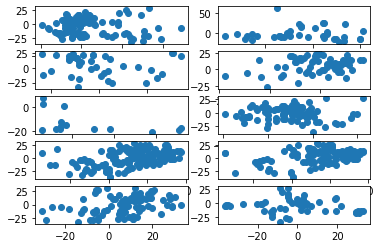

In [20]:
for lang in range(1, 11):
    label = labels[:,lang-1]
    df_tfidf_2d = pd.DataFrame({'x': tfidf_2d[:,0], 'y': tfidf_2d[:,1], 'label':label})
    
    plt.subplot(5,2, lang)
    filt = df_tfidf_2d['label'] == 1
    plt.scatter(df_tfidf_2d['x'][filt], df_tfidf_2d['y'][filt])

# Label Relations

In [43]:
from skmultilearn.dataset import load_dataset
X_train, y_train, feature_names, label_names_1 = load_dataset('emotions', 'train')

emotions:train - exists, not redownloading


In [44]:
from skmultilearn.cluster import LabelCooccurrenceGraphBuilder

In [45]:
x = vectorizer.fit_transform(documents)
y = MultiLabelBinarizer().fit_transform(df_subset['tags_new'])

In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [47]:
label_names = df_subset['tags_new'].tolist()

In [48]:
graph_builder = LabelCooccurrenceGraphBuilder(weighted=True, include_self_edges=False)

In [49]:
edge_map = graph_builder.transform(y_train)

In [50]:
from skmultilearn.cluster.networkx import NetworkXLabelGraphClusterer

# we define a helper function for visualization purposes
def to_membership_vector(partition):
    return {
        member :  partition_id
        for partition_id, members in enumerate(partition)
        for member in members
    }

In [51]:
clusterer = NetworkXLabelGraphClusterer(graph_builder, method='louvain')

In [52]:
partition = clusterer.fit_predict(x_train,y_train)
membership_vector = to_membership_vector(partition)

In [53]:
import networkx as nx
names_dict = dict(enumerate(x[0].replace('-','-\n') for x in label_names))

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline

In [126]:
#nx.draw(
#    clusterer.graph_,
#    pos=nx.circular_layout(clusterer.graph_),
#    labels=names_dict,
#    with_labels = True,
#    width = [10*x/y_train.shape[0] for x in clusterer.weights_['weight']],
#    node_color = [membership_vector[i] for i in range(y_train.shape[1])],
#    cmap=plt.cm.Spectral,
#    node_size=100,
#    font_size=14
#)

# TF-IDF and Random Forest (OneVsRest)

In [95]:
x = documents
y = MultiLabelBinarizer().fit_transform(df_subset['tags_new'].tolist())

In [96]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [98]:
estimators = [('tfidf', TfidfVectorizer()), ('clf', OneVsRestClassifier(RandomForestClassifier()))]
parameters = {'tfidf__max_features': [1000, 2000], 
              'clf__estimator__n_estimators': [100],
             'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)]}

In [99]:
p = Pipeline(estimators)
grid = GridSearchCV(p, param_grid=parameters, cv=5, return_train_score=True)

In [101]:
score = grid.fit(x_train, y_train);

C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [102]:
y_pred = grid.predict(x_test)

In [103]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.92      0.52      0.67        21
           1       0.00      0.00      0.00         7
           2       1.00      0.15      0.27        13
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         3
           5       0.88      0.44      0.58        16
           6       0.79      0.79      0.79        34
           7       0.71      0.52      0.60        23
           8       0.91      0.56      0.69        18
           9       1.00      0.36      0.53        11

   micro avg       0.83      0.45      0.58       162
   macro avg       0.62      0.34      0.41       162
weighted avg       0.72      0.45      0.53       162
 samples avg       0.48      0.46      0.46       162

0.35658914728682173


The model has a lot of problems that must be addressed:
<ul>
    <li>Too few samples</li>
    <li>Class imbalance when spliting into training and evaluation dasets</li>
    <li>Hyperparameter tuning</li>
    <li>Feature selection (context is not considered) and weighting</li>
</ul>        
It is just a first evaluation.

# TF-IDF and Random Forest (Label Powerset)

In [104]:
from skmultilearn.problem_transform import LabelPowerset

In [105]:
estimators = [('tfidf', TfidfVectorizer()), ('clf', LabelPowerset(RandomForestClassifier()))]
parameters = {'tfidf__max_features': [1000, 2000], 
              'clf__estimator__n_estimators': [100],
             'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3)]}

In [106]:
classifier = LabelPowerset(RandomForestClassifier())

In [107]:
vectorizer = TfidfVectorizer()
x_train_2 = vectorizer.fit_transform(x_train)

In [108]:
classifier.fit(x_train_2, y_train);

C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [109]:
score = classifier.fit(x_train_2, y_train);

In [110]:
x_test_2 = vectorizer.transform(x_test)

In [111]:
y_pred = classifier.predict(x_test_2)

In [112]:
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.71      0.70        21
           1       0.00      0.00      0.00         7
           2       0.86      0.46      0.60        13
           3       0.00      0.00      0.00        16
           4       0.00      0.00      0.00         3
           5       0.50      0.56      0.53        16
           6       0.65      0.82      0.73        34
           7       0.54      0.65      0.59        23
           8       0.77      0.56      0.65        18
           9       0.60      0.82      0.69        11

   micro avg       0.61      0.57      0.59       162
   macro avg       0.46      0.46      0.45       162
weighted avg       0.55      0.57      0.55       162
 samples avg       0.63      0.60      0.59       162

0.4496124031007752


# Multi-Label K-Nearest Neighbor

In [113]:
from skmultilearn.adapt import MLkNN

In [114]:
parameters = {'k': range(1,3), 's': [0.5, 0.7, 1.0]}
clf = GridSearchCV(MLkNN(), parameters, scoring='f1_macro')

y_pred = clf.fit(x_train_2, y_train).predict(x_test_2)

C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted sample

In [115]:
import sklearn.metrics as metrics
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.85      0.52      0.65        21
           1       0.33      0.43      0.38         7
           2       0.53      0.69      0.60        13
           3       0.25      0.06      0.10        16
           4       0.00      0.00      0.00         3
           5       0.57      0.25      0.35        16
           6       0.36      0.15      0.21        34
           7       0.62      0.43      0.51        23
           8       0.56      0.28      0.37        18
           9       0.36      0.45      0.40        11

   micro avg       0.50      0.33      0.40       162
   macro avg       0.44      0.33      0.36       162
weighted avg       0.50      0.33      0.38       162
 samples avg       0.37      0.35      0.35       162

0.2868217054263566
0.1248062015503876


# Community Detection

In [116]:
from skmultilearn.ensemble import LabelSpacePartitioningClassifier
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [121]:
classifier = LabelSpacePartitioningClassifier(
    classifier = LabelPowerset(classifier=RandomForestClassifier()),
    clusterer = clusterer
)

In [124]:
classifier.fit(x_train_2, y_train)
y_pred = classifier.predict(x_test_2)

C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [125]:
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\C311723\.conda\envs\env_nlp_text_class\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.64      0.33      0.44        21
           1       0.00      0.00      0.00         7
           2       1.00      0.23      0.38        13
           3       0.50      0.06      0.11        16
           4       0.00      0.00      0.00         3
           5       0.83      0.31      0.45        16
           6       0.77      0.50      0.61        34
           7       0.65      0.65      0.65        23
           8       0.75      0.33      0.46        18
           9       1.00      0.64      0.78        11

   micro avg       0.74      0.38      0.50       162
   macro avg       0.61      0.31      0.39       162
weighted avg       0.70      0.38      0.47       162
 samples avg       0.39      0.38      0.37       162

0.2868217054263566


# BERT

In [ ]:
!pip install bert-tensorflow

In [ ]:
BERT_MODEL_HUB = 'https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1'
BERT_VOCAB = 'data/uncased-l12-h768-a12/vocab.txt'
BERT_INIT_CHKPNT = 'data/uncased-l12-h768-a12/bert_model.ckpt'
BERT_CONFIG = 'data/uncased-l12-h768-a12/bert_config.json'

# Tensorflow

In [ ]:
df_subset.head()

In [ ]:
x = df_subset['body_new'].apply(lambda array: ' '.join(array))
y = MultiLabelBinarizer().fit_transform(df_subset['tags_new'])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [ ]:
vectorizer = TfidfVectorizer()
sparse_tfidf_texts = vectorizer.fit_transform(x_train)